In [339]:
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import os
import re
import datetime as dt
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")
%matplotlib inline  

# Question1:

Try to rationalize your choice of instruments. What are the economic
reasons for tight price relationship?

## Choice:

One of the most prevalent and oft-researched pairs relationships has remained between the world's two largest payment processors, Visa (NYSE: V ) and MasterCard (NYSE: MA ) .

These two financial transaction companies are roughly the same size, (120 to 140 billion in market cap), engage in comparable businesses, and have maintained a correlated (although at times volatile) relationship for years.

resouces from: https://www.nasdaq.com/articles/2-stocks-ultimate-pairs-trade-2014-04-02

In [327]:
def getYahooData(ticker):
    #import pandas_datareader.data as web
    start = dt.datetime(2020,1,1)
    end =  dt.datetime(2020,12,9) #dt.datetime.now()

    df_stock = web.DataReader(ticker, 'yahoo', start, end)
    return df_stock

In [340]:
tickers = ['V','MA'] # VISA and MasterCard
stock1 = getYahooData(tickers[0])
stock2 = getYahooData(tickers[1])

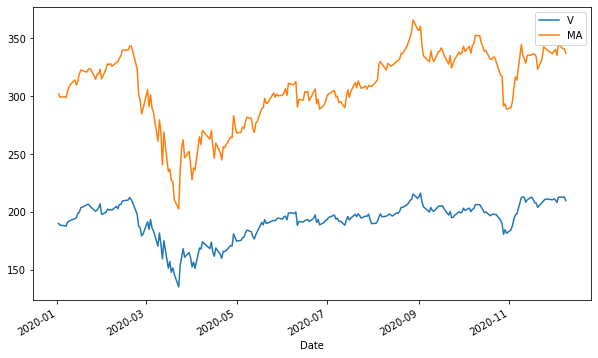

In [341]:
df = pd.DataFrame(columns=tickers)
df[tickers[0]]=stock1['Adj Close'].copy()
df[tickers[1]]=stock2['Adj Close'].copy()
df.plot(figsize=(10,6))

# Question 2: 

Below we denote price series for these instruments as A(t) and B(t).
<br> Try to apply ”Cointegration approach”.
<br> For each date ”t” select ”In sample” period $ [t − L, t − 1] $ where $L$ is the length of the time window used for training.
<br> Estimate residuals via the following linear regression:
$A(\tau)=\alpha+\beta*B(\tau)+R(\tau),\tau\in[t-L,t-1]$
<br> where $\alpha$ is intercept and $\beta$ is regression coefficient and $R(\tau)$ is time series of residuals.
<br> Construct Z-scores, defined as $Z(t)=\frac {R(t)}{S(\tau)}$ where $S(\tau)$ is the volatility of the residual

In [344]:
L = 5

data = []
for i in range(len(df) - L):
    data.append(df.iloc[i: i + L])

data = np.array([d.values for d in data])
data.shape

(233, 5, 2)

In [345]:
vol = [] # record the volatility of each window
ab = [] # record the intercept and coefficient
residuals = [] # record all residual of each window
Z_t = [] # record Z_tau of each window

for i in range(len(data)):
    y = np.array(data[i][:,0]).reshape(-1,1) # V
    X = np.array(data[i][:,1]).reshape(-1,1) # MA
    
    reg = LinearRegression().fit(X, y)
    ab.append((reg.intercept_[0],reg.coef_[0][0]))

    # residuals from 1 to tau
    residual = y - reg.predict(X)
    residuals.append(residual)
    vol.append(residual.std())
    ind =  i + L
    z = (df.iloc[ind,0]-reg.predict(np.array(df.iloc[ind,1]).reshape(-1,1))) /vol[-1] # (y-y_hat)/vol
    Z_t.append(z[0][0])

In [212]:
# show the first 15
print(list(zip(Z_t[:L],df.index[L:30])))

[(-0.16887884041112644, Timestamp('2020-01-24 00:00:00')), (1.2240659545445545, Timestamp('2020-01-27 00:00:00')), (-0.0710099806444342, Timestamp('2020-01-28 00:00:00')), (1.0351915904024456, Timestamp('2020-01-29 00:00:00')), (0.9050636374061586, Timestamp('2020-01-30 00:00:00')), (-0.28541074548729417, Timestamp('2020-01-31 00:00:00')), (-3.483624492113725, Timestamp('2020-02-03 00:00:00')), (-2.613252150901983, Timestamp('2020-02-04 00:00:00')), (-1.885119082165884, Timestamp('2020-02-05 00:00:00')), (-1.3289205078707307, Timestamp('2020-02-06 00:00:00')), (-0.8376790939962806, Timestamp('2020-02-07 00:00:00')), (0.32176026474354674, Timestamp('2020-02-10 00:00:00')), (-0.6065121311335703, Timestamp('2020-02-11 00:00:00')), (0.7501564032782315, Timestamp('2020-02-12 00:00:00')), (0.6393514675199068, Timestamp('2020-02-13 00:00:00'))]


0.06400792491295838


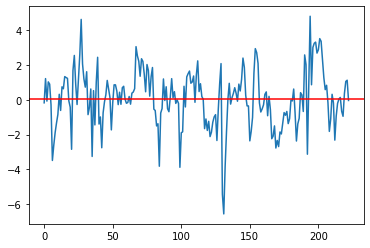

In [213]:
plt.plot(Z_t)
plt.axhline(y=sum(Z_t)/len(Z_t), color='r', linestyle='-')
print(sum(Z_t)/len(Z_t))

# Question 3: 

For each ”In sample” $[t − L, t − 1]$ period estimate optimal entry and exit points by analyzing the behavior of $Z(t)$. 
<br> Apply these trading rules to the ”out of sample period” $[t + 1, t + W]$ where $W$ is the length of the window used for trading.


Trading Rule:
<li> if Zscore is greater than $\Delta$, the first stock is overvalued in terms of the second stock, so we short 1 unit $stock_{1,t}$ and long 1 units $stock_{2,t}$

<li> if Zscore is less than $-\Delta$, the first stock is undervalued in terms of the second stock, so we long 1 unit $stock_{1,t}$ and short 1 units $stock_{2,t}$

In [325]:
def zScore(*args):
    (alpha,beta,std,y,x) = args
    return (y-(alpha+beta*x))/std


W == len(vol)-1
for i in range(W):
    ind =  i + L
    z = zScore(ab[i][0],ab[i][1],vol[i],df.iloc[ind,0],df.iloc[ind,1])

In [287]:
df = df.iloc[L:].copy()
df['v_ret']=df['V'].pct_change()
df['ma_ret']=df['MA'].pct_change()
df['z'] = Z_t
df['trade_v'] = 0
df['trade_ma'] = 0
df.head()

,V,MA,v_ret,ma_ret,z,trade_v,trade_ma,port_ret,cum_ret
Date,,,,,,,,,
2020-01-24,203.745880,322.363892,NaN,NaN,-0.168879,0,0,0,0
2020-01-27,200.456131,314.495728,-0.016146,-0.024408,1.224066,0,0,0,0
2020-01-28,201.609024,318.977570,0.005751,0.014251,-0.071010,0,0,0,0
2020-01-29,203.606720,319.027405,0.009909,0.000156,1.035192,0,0,0,0
2020-01-30,206.936249,323.150665,0.016353,0.012924,0.905064,0,0,0,0


In [288]:
delta = 2
opening = 0
for i,z in enumerate(df.z):
    if z > delta:
        if opening == 0:
            opening = 1
        elif opening == 1:
            df.trade_v.iloc[i] = -1
            df.trade_ma.iloc[i] = 1
        elif opening == -1:
            df.trade_v.iloc[i] = 1
            df.trade_ma.iloc[i] = -1
            opening = 0
    elif z < -delta:
        if opening == 0:
            opening = -1
        elif opening == -1:
            df.trade_v.iloc[i] = 1
            df.trade_ma.iloc[i] = -1
        elif opening == 1:
            df.trade_v.iloc[i] = -1
            df.trade_ma.iloc[i] = 1
            opening = 0
    else:
        if opening != 0:
#             if (z > 0 and opening == -1) or (z < 0 and opening == 1):
#                 opening = 0
#             df.trade_v.iloc[i] = df.trade_v.iloc[i-1]
#             df.trade_ma.iloc[i] = df.trade_ma.iloc[i-1]
            
            if opening == -1:
                if z > 0:
                    opening = 0
                df.trade_v.iloc[i] = 1
                df.trade_ma.iloc[i] = -1
            else:
                if z < 0:
                    opening = 0
                df.trade_v.iloc[i] = -1
                df.trade_ma.iloc[i] = 1

# Question 4: 

Calculate cumulative pnl, sharpe ratio and drawdowns of your strategy

IDEA:
<br>Here I use adjust close price to my calculation and apply dollar neutra. Suppose I have 100 dollars that 50 for short and 50 for long

In [ ]:
df['port_ret'] = (df.trade_v*df.v_ret + df.trade_ma*df.ma_ret)/2
df['cum_ret'] = (df.port_ret+1).cumprod()

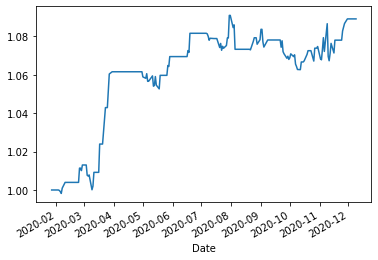

In [298]:
df['cum_ret'].plot()

In [306]:
final_ret = df.cum_ret[-1]-1
port_std = df[df.port_ret!=0].port_ret[1:].std()

sharp_ratio = final_ret/port_std
print("sharp_ratio with risk-free rate: ", sharp_ratio)

sharp_ratio with risk-free rate:  17.77903240253079


In [312]:
df.port_ret[0]=0
df.cum_ret[0]=0
df['max']=np.maximum.accumulate(df['cum_ret'])

# calculate max drawdown, depth, and recovery time
df['mdd'] = 0
df['mdepth'] = 0
df['recovery time'] = 0
peak = -1 # peak index
peak2 = -1 # peak2 index, recover = peak - peak2
for i in range(0, len(df)):
    if df['max'].iloc[i] == df['cum_ret'].iloc[i]:
        if peak == -1 and peak2 == -1:
            peak = peak2 = i
        else:
            peak = i
        
        if df['mdd'].iloc[i-1] > 0:
            df['mdepth'].iloc[i-1] = df['mdd'].iloc[i-1]
            df['recovery time'].iloc[i] = peak - peak2
        peak2 = peak
        
    else:
        res = df['max'].iloc[i] - df['cum_ret'].iloc[i]
        if res > df['mdd'].iloc[i-1]:
            df['mdd'].iloc[i] = res 
        else:
            df['mdd'].iloc[i] = df['mdd'].iloc[i-1]
    

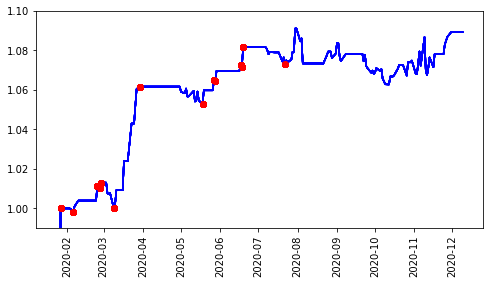

In [322]:
#plot mdd with adjust close price  
time_of_drawdown = []
temp = pd.DataFrame(columns=['Date','cum_ret'])
for i in range(1,len(df)):
    if(df['mdepth'].iloc[i] != 0):
        pos = str(df[df['mdd'] == df['mdepth'].iloc[i]].index.tolist()[0]).split()[0]
        pos_data = str(df[df['cum_ret'] == df.loc[pos,'max']].index.tolist()[0]).split()[0]
        
        time_of_drawdown.append('({}'.format(pos_data) + ',' + '{})'.format(pos))
        temp = temp.append({'Date':pos_data,'cum_ret':df.loc[pos_data,'cum_ret']},ignore_index=True)
        temp = temp.append({'Date':pos,'cum_ret':df.loc[pos,'cum_ret']},ignore_index=True)
temp['Date']=pd.to_datetime(temp['Date'])
temp = temp.set_index('Date',drop=True)

plt.figure(figsize=(8,4))
plt.xticks(rotation=90)

plt.ylim(0.99, 1.1)
for i in range(len(temp)):
    plt.plot(df['cum_ret'],color='blue')
    plt.plot(temp.index,temp,'o',color='red')

# Question 5: 

Explore the sensitivity of your strategy to change in parameters: $L, W$ and entry and exit points.

In [365]:
def Ltest(df, L):
    data = []
    for i in range(len(df) - L):
        data.append(df.iloc[i: i + L])

    data = np.array([d.values for d in data])
    
    vol = [] # record the volatility of each window
    ab = [] # record the intercept and coefficient
    residuals = [] # record all residual of each window
    Z_t = [] # record Z_tau of each window

    for i in range(len(data)):
        y = np.array(data[i][:,0]).reshape(-1,1) # V
        X = np.array(data[i][:,1]).reshape(-1,1) # MA

        reg = LinearRegression().fit(X, y)
        ab.append((reg.intercept_[0],reg.coef_[0][0]))

        # residuals from 1 to tau
        residual = y - reg.predict(X)
        residuals.append(residual)
        vol.append(residual.std())
        ind =  i + L
        z = (df.iloc[ind,0]-reg.predict(np.array(df.iloc[ind,1]).reshape(-1,1))) /vol[-1] # (y-y_hat)/vol
        Z_t.append(z[0][0])
    
    df = df.iloc[L:].copy()
    df['v_ret']=df['V'].pct_change()
    df['ma_ret']=df['MA'].pct_change()
    df['z'] = Z_t
    df['trade_v'] = 0
    df['trade_ma'] = 0
    
    delta = 2
    opening = 0
    for i,z in enumerate(df.z):
        if z > delta:
            if opening == 0:
                opening = 1
            elif opening == 1:
                df.trade_v.iloc[i] = -1
                df.trade_ma.iloc[i] = 1
            elif opening == -1:
                df.trade_v.iloc[i] = 1
                df.trade_ma.iloc[i] = -1
                opening = 0
        elif z < -delta:
            if opening == 0:
                opening = -1
            elif opening == -1:
                df.trade_v.iloc[i] = 1
                df.trade_ma.iloc[i] = -1
            elif opening == 1:
                df.trade_v.iloc[i] = -1
                df.trade_ma.iloc[i] = 1
                opening = 0
        else:
            if opening != 0:
    #             if (z > 0 and opening == -1) or (z < 0 and opening == 1):
    #                 opening = 0
    #             df.trade_v.iloc[i] = df.trade_v.iloc[i-1]
    #             df.trade_ma.iloc[i] = df.trade_ma.iloc[i-1]

                if opening == -1:
                    if z > 0:
                        opening = 0
                    df.trade_v.iloc[i] = 1
                    df.trade_ma.iloc[i] = -1
                else:
                    if z < 0:
                        opening = 0
                    df.trade_v.iloc[i] = -1
                    df.trade_ma.iloc[i] = 1
                    
    df['port_ret'] = (df.trade_v*df.v_ret + df.trade_ma*df.ma_ret)/2
    df['cum_ret'] = (df.port_ret+1).cumprod()
    final_ret = df.cum_ret[-1]-1
    port_std = df[df.port_ret!=0].port_ret[1:].std()

    sharp_ratio = final_ret/port_std
    print("sharp_ratio with risk-free rate and L = {}: ".format(L), sharp_ratio)
    return sharp_ratio.copy()

In [366]:
sharp_ratios = []
for i in range(5,65,5):
    sharp_ratios.append(Ltest(df, i))

sharp_ratio with risk-free rate and L = 5:  26.436320354216928
sharp_ratio with risk-free rate and L = 10:  17.015439460690043
sharp_ratio with risk-free rate and L = 15:  17.77903240253079
sharp_ratio with risk-free rate and L = 20:  14.03209001280351
sharp_ratio with risk-free rate and L = 25:  21.639085053405534
sharp_ratio with risk-free rate and L = 30:  7.1571013188792385
sharp_ratio with risk-free rate and L = 35:  9.98740862509911
sharp_ratio with risk-free rate and L = 40:  11.331205687419354
sharp_ratio with risk-free rate and L = 45:  10.032389229277554
sharp_ratio with risk-free rate and L = 50:  4.7371112529959865
sharp_ratio with risk-free rate and L = 55:  3.297703725804829
sharp_ratio with risk-free rate and L = 60:  0.9497138380154297


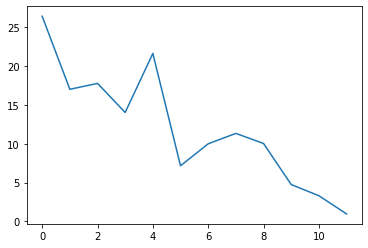

In [368]:
plt.plot(sharp_ratios)

As we can see that, even though the sharp ratio is not a straight line, but it has a downward trend, which indicates that if L is increase, the sharp ratio of the pair trading would final decrease to some level. The highes level is when L is 5 in this case.

After looking at the outputs, I think W is not the factor that has a significant influence to the return because whatever L is changed, I will set W equals to the whole data range. While, L decides the final return, followings are the test after changing L

In [ ]:
df.to_csv("result.csv")